In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy.optimize import curve_fit

# IMPORTANDO A BASE DE DADOS

In [256]:
df = pd.read_csv('DataBase.csv')
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,259.994904
1,01 01 2018 00:10,453.769196,5.672167,268.641113
2,01 01 2018 00:20,306.376587,5.216037,272.564789
3,01 01 2018 00:30,419.645905,5.659674,271.258087
4,01 01 2018 00:40,380.650696,5.577941,265.674286


In [257]:
df.rename(columns={
    'LV ActivePower (kW)' : 'power',
    'Wind Speed (m/s)'    : 'windSpeed', 
    'Wind Direction (°)'  : 'windDirection'
}, inplace=True)

df.head()

,Date/Time,power,windSpeed,windDirection
0,01 01 2018 00:00,380.047791,5.311336,259.994904
1,01 01 2018 00:10,453.769196,5.672167,268.641113
2,01 01 2018 00:20,306.376587,5.216037,272.564789
3,01 01 2018 00:30,419.645905,5.659674,271.258087
4,01 01 2018 00:40,380.650696,5.577941,265.674286


# DISTRIBUIÇÃO DA VARIÁVEL DESEJADA
A variável principal é a potência da turbina, queremos saber os fatores que alteram essa potência com base nos dados. Para isso, precisamos saber como a função se distribui de acordo com sua frequência.

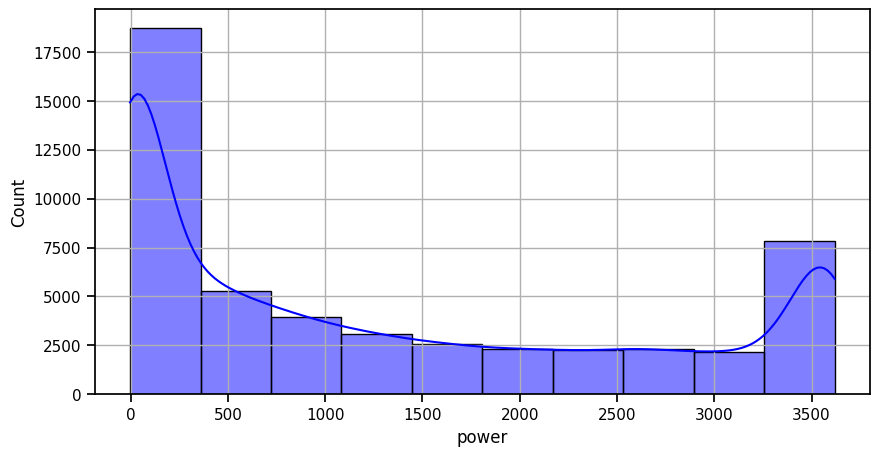

In [258]:
sns.set_context('notebook', font_scale= 1)
plt.figure(figsize=(10, 5))
ax = sns.histplot(data=df, x='power', color='blue', kde=True, bins=10)
plt.grid()
plt.show()

Percebe-se que a frequência das potências é bem distribuída, e a função abaixo mostra que 97% dos dados se encontram no intervalo $500 \leq x < 3650$

In [259]:
def prob(data, a, b):
    sum = 0
    
    for value in data:
        if a < value <= b:
            sum += 1
    
    return sum/len(data)


prob(df.power, 500, 3650)

0.5837324361765288

# COMPORTAMENTO DIREÇÃO X POTÊNCIA
Vamos primeiramente identificar como a potência se comporta em relação à direção do vento, para que se possa encontrar as direções em que há maior potência na turbina. Como todos os dados são contínuos, vamos fazer um scatterplot

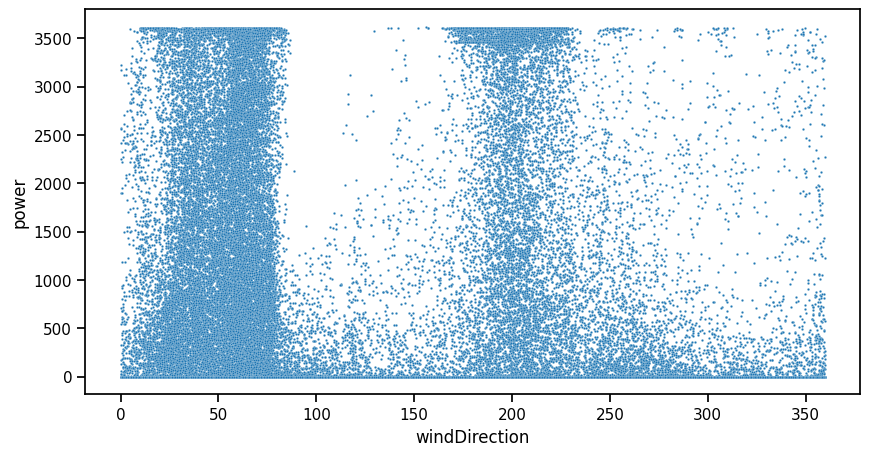

In [260]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df.windDirection, y=df.power, s=3)
plt.show()

Nenhuma relação de função entre as duas variáveis. Mas percebemos que os valores se concentram em 0 a 150 e em 150 a 200, o que mostra que o vento ocorre com mais frequência nessas direções

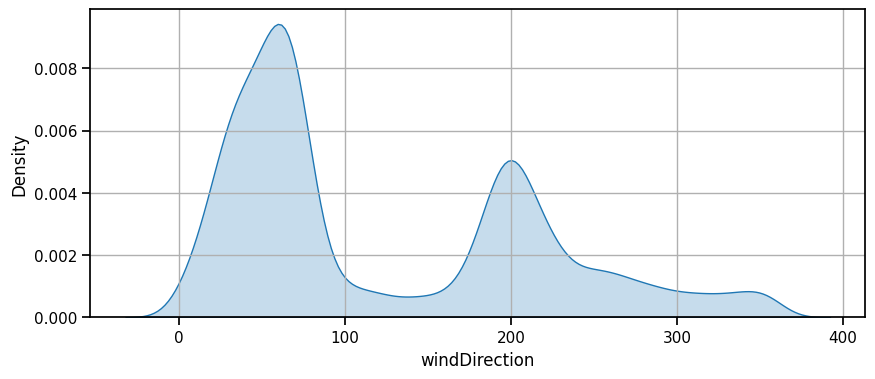

In [261]:
plt.figure(figsize=(10, 4))
sns.kdeplot(df.windDirection, fill=True)
plt.grid()
plt.show()

Vamos agora encontrar essa frequência de forma mais geral pelos pontos cardeais em um gráfico de pizza

In [262]:
def getDirection(x):
    direções   = ['NNE', 'ENE', 'ESE', 'SSE', 'SSW', 'WSW', 'WNW', 'NNW']
    intervalos = [(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)] 
    
    for i, direcao in enumerate(direções):
        lower = intervalos[i][0]
        upper = intervalos[i][1]

        if lower < x <= upper:
            return direcao

    return 'None'


df['directionClass'] = df.windDirection.apply(getDirection)
df.sample(frac=0.20).head()

,Date/Time,power,windSpeed,windDirection,directionClass
1761,13 01 2018 09:10,3361.974121,11.727850,63.637039,ENE
48698,19 12 2018 06:40,2245.498047,13.557000,8.122368,NNE
29613,30 07 2018 21:00,698.268372,6.647095,78.300041,ENE
25654,03 07 2018 09:10,87.527924,3.765815,81.178810,ENE
45379,26 11 2018 02:40,3602.096924,18.720831,195.326202,SSW


In [263]:
fig = px.pie(df, values='windDirection', names='directionClass', title='Distribuição do Vento')
fig.show()

# RELAÇÃO VELOCIDADE X POTÊNCIA
Vamos agora observar como a potência se comporta com relação à velocidade do vento, como os dados são contínuos, usamos o scatterplot

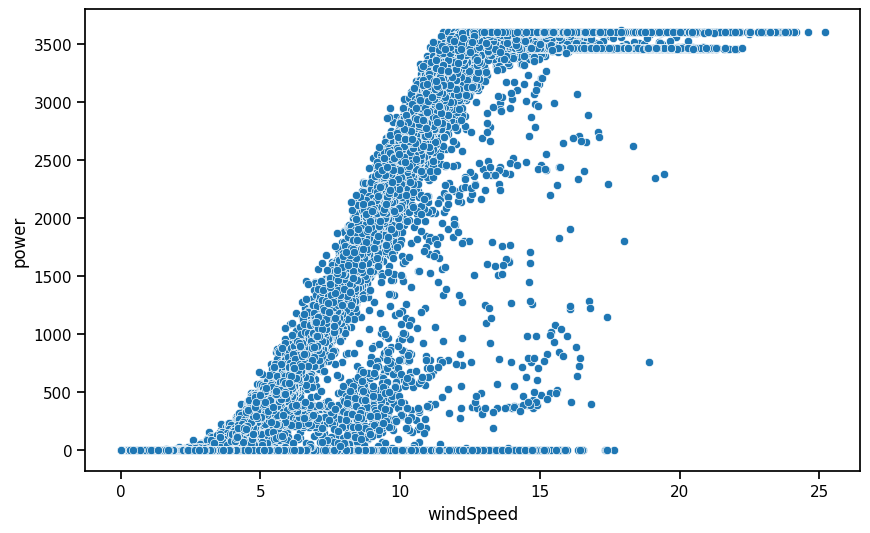

In [264]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.windSpeed, y=df.power)
plt.show()

Percebemos um padrão de função entre as duas variáveis, mas vamos ter certeza pegando uma pequena amostra dos dados (para diminuir o número de outliers) e diminuir o tamanho dos pontos, pegando apenas 20% dos dados

In [265]:
dfSample = df.sample(frac=0.2)

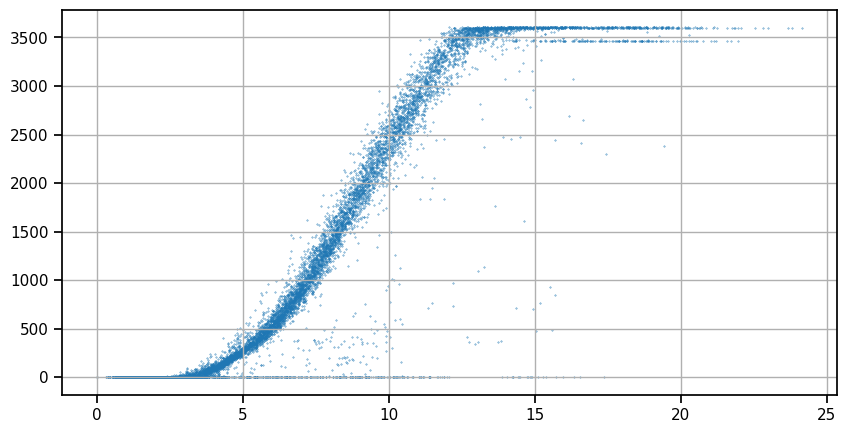

In [282]:
plt.figure(figsize=(10, 5))
plt.scatter(dfSample.windSpeed, dfSample.power, s=.1)
plt.grid()
plt.show()

Percebemos que existe uma relação de função entre as duas variáveis. Vamos encontrá-la por curve fit

### INTERPOLAÇÃO

In [267]:
def f(x, Yo, M, k):
    A = (M - Yo) / Yo
    return M / (1 + A * np.e ** (-k * x))

xDados = dfSample.windSpeed
yDados = dfSample.power
    
coefs = curve_fit(f, xDados, yDados, maxfev=1000000)[0]
xFuncao = np.linspace(min(xDados), max(xDados), 1000)
yFuncao = f(xFuncao, *coefs)

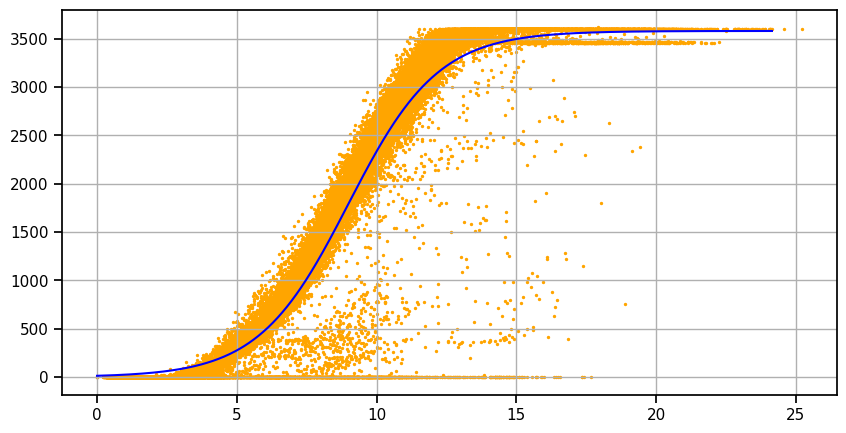

In [278]:
plt.figure(figsize=(10, 5))
plt.scatter(df.windSpeed, df.power, color='orange', s=2)
plt.plot(xFuncao, yFuncao, color='blue')
plt.grid()
plt.show()

### TRATAMENTO DOS DADOS
O intervalo aceitavel de uma potencia $P$ dada uma velocidade $v$ deve ter um intervalo de máxima extrapolação, ou seja, os dados válidos devem estar no intervalo $P(v) \pm dv$

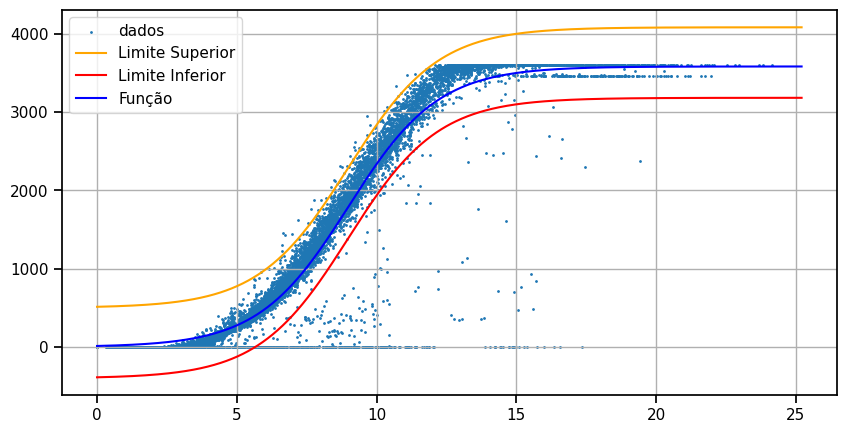

In [269]:
xData   = np.linspace(min(df.windSpeed), max(df.windSpeed), 1000)
lower_p = f(xData, *coefs) - 400
upper_p = f(xData, *coefs) + 500
function = f(xData, *coefs)

plt.figure(figsize=(10, 5))
plt.scatter(dfSample.windSpeed, dfSample.power, label='dados', s=1)
plt.plot(xData, upper_p, color='orange', label='Limite Superior')
plt.plot(xData, lower_p, color='red', label='Limite Inferior')
plt.plot(xData, function, color='blue', label='Função')
plt.grid()
plt.legend()
plt.show()

In [270]:
def treatOutliers(velocity, power):
    lower = f(velocity, *coefs) - 400
    upper = f(velocity, *coefs) + 500
    return (lower < power < upper)

df['valid'] = df.apply(lambda row: treatOutliers(row.windSpeed, row.power), axis=1)
df.head()

,Date/Time,power,windSpeed,windDirection,directionClass,valid
0,01 01 2018 00:00,380.047791,5.311336,259.994904,WSW,True
1,01 01 2018 00:10,453.769196,5.672167,268.641113,WSW,True
2,01 01 2018 00:20,306.376587,5.216037,272.564789,WNW,True
3,01 01 2018 00:30,419.645905,5.659674,271.258087,WNW,True
4,01 01 2018 00:40,380.650696,5.577941,265.674286,WSW,True


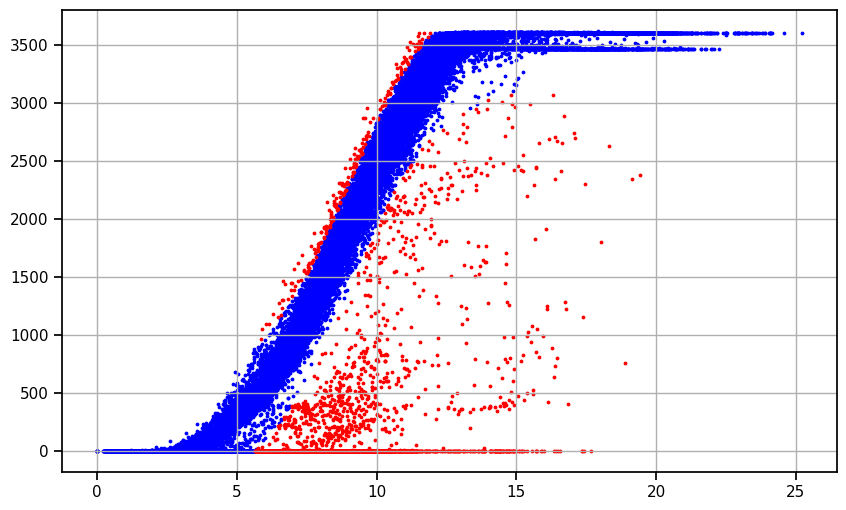

In [271]:
valid   = df.loc[df.valid]
outlier = df.loc[~df.valid]

plt.figure(figsize=(10, 6))
plt.scatter(valid.windSpeed, valid.power, s=3, color='blue')
plt.scatter(outlier.windSpeed, outlier.power, s=3, color='red')
plt.grid()
plt.show()

In [272]:
invalidos = len(outlier)/len(df) * 100
print(f'{invalidos:.2f}% dos dados são inválidos')

4.79% dos dados são inválidos
